In [1]:
import numpy as np
import pandas as pd
import pypianoroll as pr
import matplotlib.pyplot as plt
import importlib
import json
import xml.etree.ElementTree as ET
import os
import sys
import pickle
from time import time

import torch
from torch import nn
import numpy as np
from torch.nn import functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable

#### 读取数据

In [2]:
sys.path.append('..')
import dataloader
#importlib.reload(dataloader)
import model
#importlib.reload(model)
from dataloader import DataLoader
#importlib.reload(DataLoader)
from model.DeepModel import * 
#importlib.reload(model.DeepModel)
DL = DataLoader.DataLoader(device='cpu')
# DL.process_raw_data()

reading chord_num_dic
reading num_chord_dic
reading double_compressed_data


#### 统计所有和弦数目，出现的三和弦数目以及全部使用三和弦的样本数

In [3]:
total = 0  # 出现的和弦总数
triad_num = 0  # 三和弦总数
triad_num_dic = {i:0 for i in DL.chord_num_dic.keys()}
triad_sample_num = 0 # 全部使用三和弦的样本数
triad_samples = []
for sample in DL.double_compressed_data:
    sample_copy = sample.copy()
    melody = sample['melody']
    chord = sample['chord']
    t = True
    for i in range(len(melody)):
        total += 1
        try:
            DL.chord_num_dic[chord[i]]
            triad_num_dic[chord[i]] += 1
            triad_num += 1
        except:
            if len(chord[i]) < 3:
                for c in DL.chord_num_dic.keys():
                    if melody[i] not in c:
                        continue
                    for k in chord[i]:
                        if k not in c:
                            break
                    else:
                        sample_copy['chord'][i] = c
                        triad_num_dic[c] += 1
                        triad_num += 1
                        break
                else:
                    t = False
            else:
                t = False
                pass
    if t:
        triad_samples.append(sample_copy)
        triad_sample_num += 1

print(total)
print(triad_num)
print(triad_sample_num)

306469
220889
5155


In [4]:
DL.get_train_data(min_length=1, write_cache=False, valid_compressed_data=triad_samples)

10000 valid train_data
20000 valid train_data
30000 valid train_data
40000 valid train_data
50000 valid train_data
60000 valid train_data
total 61380 valid train_data


In [9]:
device = 'cuda'
model = ChordLstmNet(chord_num=39, melody_keys=12, hidden_size=128, num_layers=2, bidirectional=False,
                 alpha=0.2, device=device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)

In [11]:
train_loss = []
test_loss = []
train_data = DL.train_data[:40000]
test_data = DL.train_data[40000:]
train_data = [(sample[0].unsqueeze(0).to(device), sample[1].unsqueeze(0).to(device),
                       sample[2].unsqueeze(0).to(device), sample[3].unsqueeze(0).to(device))
                      for sample in train_data]
test_data = [(sample[0].unsqueeze(0).to(device), sample[1].unsqueeze(0).to(device),
              sample[2].unsqueeze(0).to(device), sample[3].unsqueeze(0).to(device))
             for sample in test_data]
epochs = 20
batch_size = 1000
for epoch in range(epochs):
    num = 0 
    loss = 0
    t = time()
    model.train()
    for sample in train_data:
        if num < batch_size:
            a = sample[0]
            b = sample[1]
            c = sample[2]
            out = model(a,b,c)
            loss += F.nll_loss(out, sample[3])
            num += 1
        else:
            num = 0
            loss /= batch_size
            print('loss: {:.4f} time used: {:.4f}s'.format(loss, time()-t))
            t = time()
            train_loss.append(float(loss.detach().to('cpu')))
            loss.backward()
            loss = 0
            optimizer.step()
            optimizer.zero_grad()
            
    print('epoch {} testing'.format(epoch))
    loss = 0
    with torch.no_grad():
        for sample in test_data:

            a = sample[0]
            b = sample[1]
            c = sample[2]
            out = model(a,b,c)
            loss += F.nll_loss(out, sample[3])

        loss /= len(test_data)
        test_loss.append(float(loss.detach().to('cpu')))
        print('test loss: {:.4f} time used: {:.4f}s'.format(loss, time()-t))

loss: 3.6603 time used: 0.6486s
loss: 3.6458 time used: 1.8367s
loss: 3.6470 time used: 1.7676s
loss: 3.6187 time used: 2.2396s
loss: 3.6119 time used: 1.9453s
loss: 3.5920 time used: 1.8513s
loss: 3.5598 time used: 1.7936s
loss: 3.5371 time used: 1.7463s
loss: 3.5590 time used: 1.7086s
loss: 3.4820 time used: 2.0389s
loss: 3.4434 time used: 2.3101s
loss: 3.4659 time used: 1.9358s
loss: 3.3987 time used: 1.8707s
loss: 3.3109 time used: 1.8597s
loss: 3.2207 time used: 1.6595s
loss: 3.0296 time used: 1.7886s
loss: 2.9638 time used: 1.9638s
loss: 3.0491 time used: 2.0511s
loss: 2.9961 time used: 1.8055s
loss: 2.6667 time used: 1.8687s
loss: 2.6386 time used: 1.7536s
loss: 3.0230 time used: 1.7695s
loss: 3.0014 time used: 1.7496s
loss: 2.7903 time used: 1.8852s
loss: 2.6422 time used: 2.1446s
loss: 2.7826 time used: 1.8627s
loss: 2.6939 time used: 1.8667s
loss: 2.7114 time used: 1.8752s
loss: 2.6342 time used: 1.9007s
loss: 2.7423 time used: 2.0218s
loss: 2.5892 time used: 1.8094s
loss: 2.

loss: 2.0587 time used: 1.8674s
loss: 1.8795 time used: 1.8612s
loss: 1.8956 time used: 1.7033s
loss: 1.9363 time used: 1.8563s
loss: 1.9026 time used: 1.9931s
loss: 2.0213 time used: 2.0182s
loss: 1.9455 time used: 1.7935s
loss: 1.7731 time used: 1.8651s
loss: 1.7815 time used: 1.7493s
loss: 2.0578 time used: 1.7795s
loss: 1.9625 time used: 1.7907s
loss: 1.8163 time used: 1.9091s
loss: 1.8519 time used: 2.1739s
loss: 1.9781 time used: 1.9039s
loss: 2.0188 time used: 1.8736s
loss: 1.9116 time used: 1.9428s
loss: 1.8804 time used: 2.0361s
loss: 2.0572 time used: 2.0992s
loss: 1.8280 time used: 1.9191s
loss: 1.8722 time used: 1.9691s
loss: 1.8272 time used: 2.0424s
loss: 1.8875 time used: 1.8633s
loss: 2.0017 time used: 1.9003s
loss: 1.9061 time used: 1.7986s
loss: 1.9199 time used: 1.7293s
loss: 1.8561 time used: 1.6780s
loss: 1.8946 time used: 1.8234s
epoch 6 testing
test loss: 1.9062 time used: 13.7846s
loss: 2.0246 time used: 0.6222s
loss: 1.9895 time used: 1.8842s
loss: 1.8990 time 

loss: 1.7376 time used: 2.0649s
loss: 1.8241 time used: 1.8126s
loss: 1.9384 time used: 1.8106s
loss: 1.7694 time used: 1.8967s
loss: 1.7489 time used: 1.9374s
loss: 1.9486 time used: 2.0128s
loss: 1.7191 time used: 1.8156s
loss: 1.7477 time used: 1.9057s
loss: 1.7011 time used: 2.0198s
loss: 1.8099 time used: 1.7976s
loss: 1.8706 time used: 1.7946s
loss: 1.8038 time used: 1.7386s
loss: 1.8165 time used: 1.7346s
loss: 1.7698 time used: 1.7054s
loss: 1.7726 time used: 1.7856s
epoch 12 testing
test loss: 1.8012 time used: 13.4891s
loss: 1.9169 time used: 0.6186s
loss: 1.8829 time used: 1.8743s
loss: 1.8181 time used: 1.7866s
loss: 1.6917 time used: 2.2206s
loss: 1.6056 time used: 1.9157s
loss: 2.1104 time used: 1.8423s
loss: 1.5029 time used: 1.7892s
loss: 1.6803 time used: 1.7692s
loss: 1.8346 time used: 1.7077s
loss: 1.8948 time used: 1.9958s
loss: 1.7703 time used: 2.1265s
loss: 1.9396 time used: 1.8856s
loss: 1.9359 time used: 1.8647s
loss: 1.7469 time used: 1.8787s
loss: 1.7784 time

loss: 1.7685 time used: 1.7017s
loss: 1.7340 time used: 1.6744s
loss: 1.7187 time used: 1.7726s
epoch 18 testing
test loss: 1.7638 time used: 13.5326s
loss: 1.8772 time used: 0.5955s
loss: 1.8402 time used: 1.8257s
loss: 1.7409 time used: 1.7776s
loss: 1.6687 time used: 2.2147s
loss: 1.5644 time used: 1.9465s
loss: 2.0752 time used: 1.8817s
loss: 1.4659 time used: 1.7936s
loss: 1.6551 time used: 1.7866s
loss: 1.8004 time used: 1.7012s
loss: 1.8719 time used: 2.0287s
loss: 1.7485 time used: 2.1707s
loss: 1.8675 time used: 1.9336s
loss: 1.8761 time used: 1.8819s
loss: 1.7008 time used: 1.8425s
loss: 1.7317 time used: 1.6600s
loss: 1.6193 time used: 1.8156s
loss: 1.6531 time used: 1.9799s
loss: 1.8753 time used: 2.0395s
loss: 1.7433 time used: 1.7604s
loss: 1.6176 time used: 1.8628s
loss: 1.6190 time used: 1.7166s
loss: 1.8690 time used: 1.7445s
loss: 1.7142 time used: 1.7329s
loss: 1.5683 time used: 1.8613s
loss: 1.6822 time used: 2.1860s
loss: 1.7688 time used: 1.8737s
loss: 1.8946 time

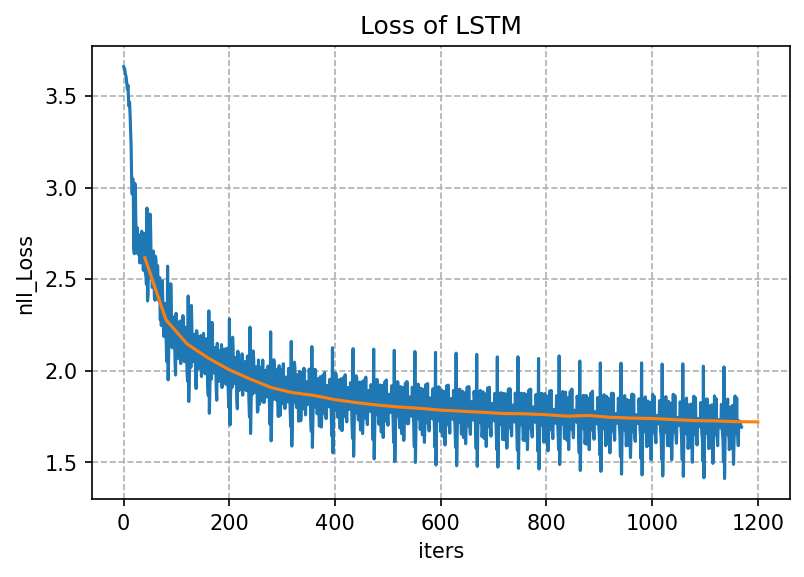

In [17]:
plt.figure(dpi=150)
plt.plot(train_loss,label='train')
plt.plot([i*40 for i in range(1,31)], test_loss, label='test')
plt.xlabel('iters')
plt.grid(linestyle='--')
plt.ylabel('nll_Loss')
plt.title('Loss of LSTM')
plt.show()

In [16]:
for epoch in range(10):
    num = 0 
    loss = 0
    t = time()
    model.train()
    for sample in train_data:
        if num < batch_size:
            a = sample[0]
            b = sample[1]
            c = sample[2]
            out = model(a,b,c)
            loss += F.nll_loss(out, sample[3])
            num += 1
        else:
            num = 0
            loss /= batch_size
            print('loss: {:.4f} time used: {:.4f}s'.format(loss, time()-t))
            t = time()
            train_loss.append(float(loss.detach().to('cpu')))
            loss.backward()
            loss = 0
            optimizer.step()
            optimizer.zero_grad()
            
    print('epoch {} testing'.format(epoch))
    loss = 0
    with torch.no_grad():
        for sample in test_data:

            a = sample[0]
            b = sample[1]
            c = sample[2]
            out = model(a,b,c)
            loss += F.nll_loss(out, sample[3])

        loss /= len(test_data)
        test_loss.append(float(loss.detach().to('cpu')))
        print('test loss: {:.4f} time used: {:.4f}s'.format(loss, time()-t))

loss: 1.8690 time used: 0.8037s
loss: 1.8374 time used: 1.9017s
loss: 1.7336 time used: 1.8126s
loss: 1.6693 time used: 2.2891s
loss: 1.5579 time used: 2.0078s
loss: 2.0660 time used: 1.9044s
loss: 1.4621 time used: 1.8268s
loss: 1.6536 time used: 1.8863s
loss: 1.7958 time used: 1.7559s
loss: 1.8734 time used: 2.0860s
loss: 1.7452 time used: 2.2419s
loss: 1.8597 time used: 1.9759s
loss: 1.8741 time used: 1.9327s
loss: 1.6984 time used: 1.9554s
loss: 1.7340 time used: 1.7331s
loss: 1.6087 time used: 1.9112s
loss: 1.6487 time used: 2.0281s
loss: 1.8737 time used: 2.0630s
loss: 1.7380 time used: 1.8128s
loss: 1.6106 time used: 1.9706s
loss: 1.6156 time used: 1.7928s
loss: 1.8605 time used: 1.8360s
loss: 1.7120 time used: 1.7967s
loss: 1.5610 time used: 1.9139s
loss: 1.6723 time used: 2.2371s
loss: 1.7653 time used: 1.9291s
loss: 1.8885 time used: 1.8675s
loss: 1.6934 time used: 1.9896s
loss: 1.6932 time used: 2.0035s
loss: 1.8910 time used: 2.1768s
loss: 1.6751 time used: 2.0209s
loss: 1.

loss: 1.8576 time used: 1.9207s
loss: 1.6618 time used: 1.9121s
loss: 1.7109 time used: 1.6865s
loss: 1.5900 time used: 1.8577s
loss: 1.6258 time used: 2.0479s
loss: 1.8311 time used: 2.0949s
loss: 1.7249 time used: 1.7656s
loss: 1.5885 time used: 1.9238s
loss: 1.6022 time used: 1.7226s
loss: 1.8223 time used: 1.7686s
loss: 1.6747 time used: 1.7806s
loss: 1.5126 time used: 1.9187s
loss: 1.6366 time used: 2.2155s
loss: 1.7271 time used: 1.8517s
loss: 1.8704 time used: 1.8086s
loss: 1.6677 time used: 1.9118s
loss: 1.6775 time used: 1.9553s
loss: 1.8630 time used: 2.0506s
loss: 1.6691 time used: 1.8592s
loss: 1.6470 time used: 1.9598s
loss: 1.6028 time used: 2.0278s
loss: 1.7376 time used: 1.8061s
loss: 1.7445 time used: 1.8307s
loss: 1.7293 time used: 1.7856s
loss: 1.7319 time used: 1.7476s
loss: 1.7105 time used: 1.7376s
loss: 1.6995 time used: 1.9368s
epoch 6 testing
test loss: 1.7270 time used: 13.5283s
loss: 1.8295 time used: 0.5975s
loss: 1.7939 time used: 1.8467s
loss: 1.6670 time 